<a href="https://colab.research.google.com/github/imkaywu/notebooks/blob/main/document_summarization_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[original post](https://github.com/thamsuppp/llm_summary_medium/blob/master/summarizing_llm.ipynb)

[Summarization - LangChain](https://python.langchain.com/docs/use_cases/summarization)

In [64]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import networkx as nx
from networkx.algorithms import community

from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

In [2]:
!pip install langchain==0.0.191
# !pip install llama-cpp-python==0.1.66
!pip install huggingface_hub
!pip install auto-gptq==0.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
  Created wheel for auto-gptq: filename=auto_gptq-0.2.2-cp310-cp310-linux_x86_64.whl size=2862516 sha256=7ee949a5ec30453ed9d15c2a3655898c146989dcee6c6f86064ea6917f4be09c
  Stored in directory: /root/.cache/pip/wheels/bf/f6/50/bb6ab784e7824cbf190a1a8205d91e6543287718fb21d5b033
Successfully built auto-gp

In [3]:
txt_path = '/content/state_of_the_union.txt'
with open(txt_path, 'r') as f:
  txt = f.read()

len(txt)

42100

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def draw_bar_chart(data):
    # Count the occurrences of each value in the array
    data_counter = Counter(data)

    # Extract values and counts for the bar chart
    values = list(data_counter.keys())
    counts = list(data_counter.values())

    # Create a bar chart
    plt.bar(values, counts)

    # Labeling the chart
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.title('Bar Chart')

    # Show the bar chart
    plt.show()

# Example usage:
# sample_data = [1, 2, 3, 1, 2, 3, 1, 1, 4, 5, 5, 5]
# draw_bar_chart(sample_data)

In [88]:
def find_overlapping_words(str1, str2):
    # Split the strings into words
    words1 = str1.split()
    words2 = str2.split()

    # Convert lists to sets to find the common elements (overlapping words)
    set1 = set(words1)
    set2 = set(words2)

    # Find the overlapping words
    overlapping_words = set1.intersection(set2)

    return overlapping_words

# Example usage:
string1 = 'This is a sample sentence with some words.'
string2 = 'Another sentence with overlapping words.'

overlapping_words = find_overlapping_words(string1, string2)
print(f'Overlapping words: {overlapping_words}')

Overlapping words: {'sentence', 'with', 'words.'}


In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 768,
    chunk_overlap = 64,
    # Use length of the text as the size measure
    length_function = len,
    # Use only "\n\n" as the separator
    separators = ['\n'],
)

In [7]:
texts = text_splitter.create_documents([txt])
print(texts[0])
print(texts[1])
print(texts[2])
print(texts[3])
print(texts[4])

page_content='Mr. Speaker. Madam Vice President. Our First Lady and Second Gentleman.\n\nMembers of Congress and the Cabinet. Leaders of our military.\n\nMr. Chief Justice, Associate Justices, and retired Justices of the Supreme Court.\n\nAnd you, my fellow Americans.\n\nI start tonight by congratulating the members of the 118th Congress and the new Speaker of the House, Kevin McCarthy.\n\nMr. Speaker, I look forward to working together.\n\nI also want to congratulate the new leader of the House Democrats and the first Black House Minority Leader in history, Hakeem Jeffries.\n\nCongratulations to the longest serving Senate Leader in history, Mitch McConnell.\n\nAnd congratulations to Chuck Schumer for another term as Senate Majority Leader, this time with an even bigger majority.' metadata={}
page_content='And I want to give special recognition to someone who I think will be considered the greatest Speaker in the history of this country, Nancy Pelosi.\n\nThe story of America is a story

In [8]:
chunks_text = [text.page_content for text in texts]

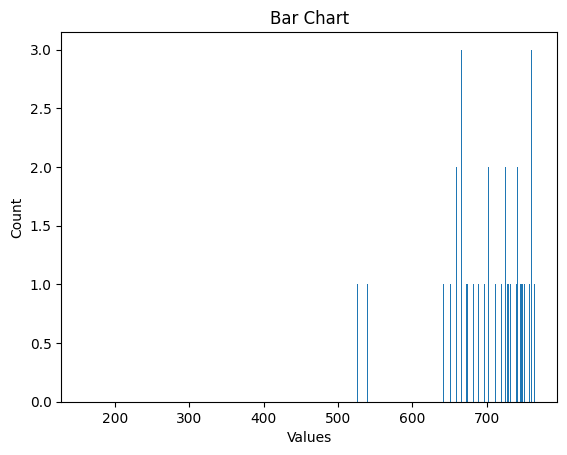

In [10]:
cnt_texts = [len(x.page_content) for x in texts]
draw_bar_chart(cnt_texts)

### Stage 1: Getting Chunk Summaries

In [10]:
import logging
import re
import requests
import torch
import pandas as pd
from tqdm import tqdm
from langchain.llms import LlamaCpp
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain # deprecated
from langchain.text_splitter import RecursiveCharacterTextSplitter
from huggingface_hub import hf_hub_download

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, pipeline

In [12]:
from auto_gptq import AutoGPTQForCausalLM

In [13]:
def load_model(device_type, model_id, model_basename=None):

    logging.info(f"Loading Model: {model_id}, on: {device_type}")
    logging.info("This action can take a few minutes!")

    if model_basename is not None:
        if ".ggml" in model_basename:
            logging.info("Using Llamacpp for GGML quantized models")
            model_path = hf_hub_download(repo_id=model_id, filename=model_basename)
            max_ctx_size = 4096
            kwargs = {
                "model_path": model_path,
                "n_ctx": max_ctx_size,
                "max_tokens": max_ctx_size,
            }
            if device_type.lower() == "mps":
                kwargs["n_gpu_layers"] = 1000
            if device_type.lower() == "cuda":
                kwargs["n_gpu_layers"] = 15000 # load everything to GPU
                kwargs["n_batch"] = max_ctx_size
            return LlamaCpp(**kwargs)

        else:
            logging.info("Using AutoGPTQForCausalLM for quantized models")

            if ".safetensors" in model_basename:
                # Remove the ".safetensors" ending if present
                model_basename = model_basename.replace(".safetensors", "")

            tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
            logging.info("Tokenizer loaded")

            model = AutoGPTQForCausalLM.from_quantized(
                model_id,
                model_basename=model_basename,
                use_safetensors=True,
                trust_remote_code=True,
                device="cuda:0",
                use_triton=False,
                quantize_config=None,
            )
    elif (
        device_type.lower() == "cuda"
    ):
        logging.info("Using AutoModelForCausalLM for full models")
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        logging.info("Tokenizer loaded")

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True,
            # max_memory={0: "15GB"} # Uncomment this line with you encounter CUDA out of memory errors
        )
        model.tie_weights()
    else:
        logging.info("Using LlamaTokenizer")
        tokenizer = LlamaTokenizer.from_pretrained(model_id)
        model = LlamaForCausalLM.from_pretrained(model_id)

    generation_config = GenerationConfig.from_pretrained(model_id)

    # Create a pipeline for text generation
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=2048,
        temperature=0,
        top_p=0.95,
        repetition_penalty=1.15,
        generation_config=generation_config,
    )

    local_llm = HuggingFacePipeline(pipeline=pipe)
    logging.info("Local LLM Loaded")

    return local_llm

In [14]:
def parse_title_summary_results(results):
  out = []
  for e in results:
    e = e.lstrip()

    title = e.split('\n')[0]
    summary = e.split('\n')[1]

    # print(title)
    # print(summary)

    title = title[title.find('Title: ')+len('Title: '):]
    summary = summary[summary.find('Summary: ')+len('Summary: '):]
    out.append({'title': title, 'summary': summary})

  return out

In [15]:
DEVICE_TYPE = "cuda" if torch.cuda.is_available() else "cpu"
SHOW_SOURCES = True
logging.info(f"Running on: {DEVICE_TYPE}")
logging.info(f"Display Source Documents set to: {SHOW_SOURCES}")

In [ ]:
# Deprecated
model_id = "TheBloke/Llama-2-7B-Chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q4_0.bin"

In [16]:
model_id = "TheBloke/Llama-2-7B-Chat-GPTQ"
model_basename = "model.safetensors"

In [17]:
LLM = load_model(device_type=DEVICE_TYPE, model_id=model_id, model_basename=model_basename)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [18]:
def summarize_stage_1(text_chunk):

    print(f'Start time: {datetime.now()}')

    # Prompt to get title and summary for each chunk
    # Defining the template to generate summary
    map_prompt_template = """
    [INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    <</SYS>>
    Write an informative but concise title, and then in a new line write a concise summary for the following text. The summary has less than 200 words. Do not return anything else.
    ```{text}```

    TITLE AND CONCISE SUMMARY:
    [/INST]"""

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
    llm_chain = LLMChain(prompt=map_prompt, llm=LLM)
    map_llm_chain_input = [{'text': t} for t in text_chunk]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = llm_chain.apply(map_llm_chain_input)

    stage_1_outputs = parse_title_summary_results([e['text'] for e in map_llm_chain_results])
    print(f'Stage 1 done time {datetime.now()}')

    return {
      'stage_1_outputs': stage_1_outputs
    }

In [54]:
# Test
stage_1_outputs = summarize_stage_1(chunks_text[:2])['stage_1_outputs']

Start time: 2023-12-29 02:00:34.941868
Stage 1 done time 2023-12-29 02:00:46.339192


In [ ]:
# Run Stage 1 Summarizing
stage_1_outputs = summarize_stage_1(chunks_text)['stage_1_outputs']

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Start time: 2023-12-29 21:56:23.625798


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# Split the titles and summaries
stage_1_summaries = [e['summary'] for e in stage_1_outputs]
stage_1_titles = [e['title'] for e in stage_1_outputs]
num_1_chunks = len(stage_1_summaries)

In [24]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [25]:
!python -m pip install -U angle-emb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 20.7 MB/s eta 0:00:00


In [26]:
# compute embedding
from angle_emb import AnglE

angle = AnglE.from_pretrained('WhereIsAI/UAE-Large-V1', pooling_strategy='cls').cuda()

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [38]:
title_embeds = np.array([angle.encode(t, to_numpy=True).squeeze() for t in stage_1_titles])
summary_embeds = np.array([angle.encode(s, to_numpy=True).squeeze() for s in stage_1_summaries])

title_embeds.shape, summary_embeds.shape

((62, 1024), (62, 1024))

In [73]:
# Get similarity matrix between the embeddings of the chunk summaries
summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
summary_similarity_matrix[:] = np.nan

for row in range(num_1_chunks):
  for col in range(row, num_1_chunks):
    # Calculate cosine similarity between the two vectors
    similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
    summary_similarity_matrix[row, col] = similarity
    summary_similarity_matrix[col, row] = similarity

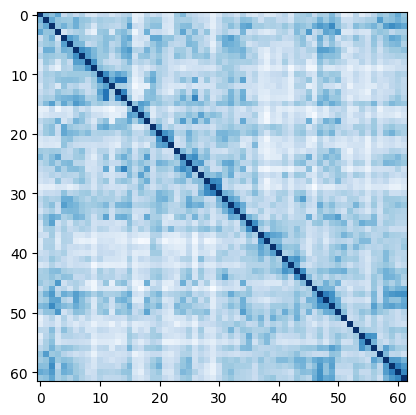

In [74]:
# Draw a heatmap with the summary_similarity_matrix
plt.figure()
# Color scheme blues
plt.imshow(summary_similarity_matrix, cmap = 'Blues')

In [41]:
# Run the community detection algorithm

def get_topics(title_similarity, num_topics = 8, bonus_constant = 0.25, min_size = 3):

  proximity_bonus_arr = np.zeros_like(title_similarity)
  for row in range(proximity_bonus_arr.shape[0]):
    for col in range(proximity_bonus_arr.shape[1]):
      if row == col:
        proximity_bonus_arr[row, col] = 0
      else:
        proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant

  title_similarity += proximity_bonus_arr

  title_nx_graph = nx.from_numpy_array(title_similarity)

  desired_num_topics = num_topics
  # Store the accepted partitionings
  topics_title_accepted = []

  resolution = 0.85
  resolution_step = 0.01
  iterations = 40

  # Find the resolution that gives the desired number of topics
  topics_title = []
  while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    resolution += resolution_step
  topic_sizes = [len(c) for c in topics_title]
  sizes_sd = np.std(topic_sizes)
  modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

  lowest_sd_iteration = 0
  # Set lowest sd to inf
  lowest_sd = float('inf')

  for i in range(iterations):
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

    # Check SD
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)

    topics_title_accepted.append(topics_title)

    if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
      lowest_sd_iteration = i
      lowest_sd = sizes_sd

  # Set the chosen partitioning to be the one with highest modularity
  topics_title = topics_title_accepted[lowest_sd_iteration]
  print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}')

  topic_id_means = [sum(e)/len(e) for e in topics_title]
  # Arrange title_topics in order of topic_id_means
  topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
  # Create an array denoting which topic each chunk belongs to
  chunk_topics = [None] * title_similarity.shape[0]
  for i, c in enumerate(topics_title):
    for j in c:
      chunk_topics[j] = i

  return {
    'chunk_topics': chunk_topics,
    'topics': topics_title
    }

In [76]:
# Set num_topics to be 1/4 of the number of chunks, or 8, which ever is smaller
num_topics = min(int(num_1_chunks / 4), 8)
topics_out = get_topics(summary_similarity_matrix, num_topics = num_topics, bonus_constant = 0.3)
chunk_topics = topics_out['chunk_topics'] # chunk to topics
topics = topics_out['topics'] # topic to chunks

Best SD: 1.3698697784375504, Best iteration: 15


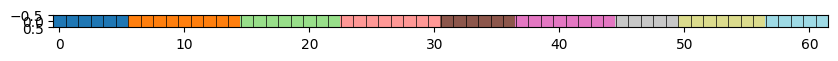

In [77]:
# Plot a heatmap of this array
plt.figure(figsize = (10, 4))
plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
# Draw vertical black lines for every 1 of the x-axis
for i in range(1, len(chunk_topics)):
  plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

### Stage 2 Summaries

In [65]:
def summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250):
  print(f'Stage 2 start time {datetime.now()}')

  # Prompt that passes in all the titles of a topic, and asks for an overall title of the topic
  title_prompt_template = """Write an informative title that summarizes each of the following groups of titles. Make sure that the titles capture as much information as possible,
  and are different from each other:
  {text}

  Return your answer in a numbered list, with new line separating each title:
  1. Title 1
  2. Title 2
  3. Title 3

  TITLES:
  """

  map_prompt_template = """Wite a 75-100 word summary of the following text:
    {text}

    CONCISE SUMMARY:"""

  combine_prompt_template = 'Write a ' + str(summary_num_words) + """-word summary of the following, removing irrelevant information. Finish your answer:
  {text}
  """ + str(summary_num_words) + """-WORD SUMMARY:"""

  title_prompt = PromptTemplate(template=title_prompt_template, input_variables=["text"])
  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
  combine_prompt = PromptTemplate(template=combine_prompt_template, input_variables=["text"])

  topics_data = []
  for c in topics:
    topic_data = {
      'summaries': [stage_1_outputs[chunk_id]['summary'] for chunk_id in c],
      'titles': [stage_1_outputs[chunk_id]['title'] for chunk_id in c]
    }
    topic_data['summaries_concat'] = ' '.join(topic_data['summaries'])
    topic_data['titles_concat'] = ', '.join(topic_data['titles'])
    topics_data.append(topic_data)

  # Get a list of each community's summaries (concatenated)
  topics_summary_concat = [c['summaries_concat'] for c in topics_data]
  topics_titles_concat = [c['titles_concat'] for c in topics_data]

  # Concat into one long string to do the topic title creation
  topics_titles_concat_all = ''''''
  for i, c in enumerate(topics_titles_concat):
    topics_titles_concat_all += f'''{i+1}. {c}
    '''

  # print('topics_titles_concat_all', topics_titles_concat_all)

  title_llm_chain = LLMChain(llm = LLM, prompt = title_prompt)
  title_llm_chain_input = [{'text': topics_titles_concat_all}]
  title_llm_chain_results = title_llm_chain.apply(title_llm_chain_input)

  # Split by new line
  titles = title_llm_chain_results[0]['text'].split('\n')
  # Remove any empty titles
  titles = [t for t in titles if t != '']
  # Remove spaces at start or end of each title
  titles = [t.strip() for t in titles]

  map_llm = LLM #OpenAI(temperature=0, model_name = 'text-davinci-003')
  reduce_llm = LLM #OpenAI(temperature=0, model_name = 'text-davinci-003', max_tokens = -1)

  # Run the map-reduce chain
  docs = [Document(page_content=t) for t in topics_summary_concat]
  chain = load_summarize_chain(chain_type="map_reduce", map_prompt = map_prompt, combine_prompt = combine_prompt, return_intermediate_steps = True,
                              llm = map_llm, reduce_llm = reduce_llm)

  output = chain({"input_documents": docs}, return_only_outputs = True)
  summaries = output['intermediate_steps']
  stage_2_outputs = [{'title': t, 'summary': s} for t, s in zip(titles, summaries)]
  final_summary = output['output_text']

  # Return: stage_1_outputs (title and summary), stage_2_outputs (title and summary), final_summary, chunk_allocations
  out = {
    'stage_2_outputs': stage_2_outputs,
    'final_summary': final_summary
  }
  print(f'Stage 2 done time {datetime.now()}')

  return out

In [78]:
# Query GPT-3 to get a summarized title for each topic_data
out = summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250)
stage_2_outputs = out['stage_2_outputs']
stage_2_titles = [e['title'] for e in stage_2_outputs]
stage_2_summaries = [e['summary'] for e in stage_2_outputs]
final_summary = out['final_summary']

Stage 2 start time 2023-12-29 22:44:37.989162
[{'text': '1. "Congratulatory Remarks to New Political Leaders: A Story of Progress and Resilience"\n  2. "USA\'s Manufacturing Progress and Future Potential: Food Inflation Decreasing, The Importance of Domestic Chip Production, New Law to Create Hundreds of Thousands of Jobs Across the Country"\n  3. "A Blueprint to Rebuild America: Capping Insulin Costs for All Americans, The Impact of the Inflation Reduction Act on Prescription Drug Costs, Presidential Veto Threat and Healthcare Initiatives"\n  4. "Fiscal Responsibility and National Debt Management: President Biden\'s Address to Congress, Protecting Social Security and Medicare, Joe Biden\'s Economic Plan"\n  5. "A Plan to Support Seniors and Family Caregivers: The Importance of Pre-School Education for America\'s Future Workforce, Expanding Access to Career Opportunities"\n  6. "Losing a Child at the Hands of the Law: Courage and Character in the Face of Violence, Addressing the Needs 

In [79]:
stage_2_outputs

[{'title': '1. "Congratulatory Remarks to New Political Leaders: A Story of Progress and Resilience"',
  'summary': "\nIn his speech to mark the start of the 118th Congress, President Biden emphasized his willingness to work with new political leaders, including the first Black House Minority Leader in history. He highlighted the country's resilience in overcoming crises, such as the pandemic, and noted the creation of 12 million new jobs. The author reflected on how far the US has come since facing its greatest threat since the Civil War two years ago, and argued that the country needs to restore its middle class by addressing issues such as offshoring and factory closures. The author also emphasized the importance of bipartisan collaboration and highlighted their own efforts to create economic growth that benefits all Americans."},
 {'title': '2. "USA\'s Manufacturing Progress and Future Potential: Food Inflation Decreasing, The Importance of Domestic Chip Production, New Law to Crea

In [80]:
final_summary

"\nPresident Biden emphasized his commitment to working with new political leaders in his speech to mark the start of the 118th Congress. He highlighted the country's resilience in overcoming crises, such as the pandemic, and noted the creation of 12 million new jobs. The author discussed the progress made during the current administration, focusing on job creation, reducing the national debt, and addressing issues such as medical bills and prescription drug prices. The article also touched upon the need to address the climate crisis, reform the tax system, and improve America's education system. Various issues related to public safety were addressed, including police brutality, gun violence, and immigration reform. The article concluded by stressing the importance of standing up against political violence and defending democracy in America."